## Previsão de Votação de Deputados


### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn import model_selection
import missingno as msno
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

### Leitura dos dados

In [2]:
train = pd.read_csv('eleicoes_2006_a_2010.csv')
test = pd.read_csv('eleicoes_2014.csv')
test.columns = train.columns            

Nesta atividade construiremos modelos preditivos de regressão em scikit learn para a predição dos votos de deputados federais considerando as eleições de 2006, 2010 e 2014. 

In [3]:
all_data = pd.concat([train, test], ignore_index=True)
all_data.head(4)

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,votos
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.666667,NaN,...,14,14,16583.60,1184.542857,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,8579
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.846154,6625.0,...,24,23,20325.99,883.738696,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,2757
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,148120.80,9257.550000,2250.0,...,123,108,146011.70,1351.960185,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,17428
3,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.186667,NaN,...,8,8,3001.12,375.140000,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,1193


<AxesSubplot:>

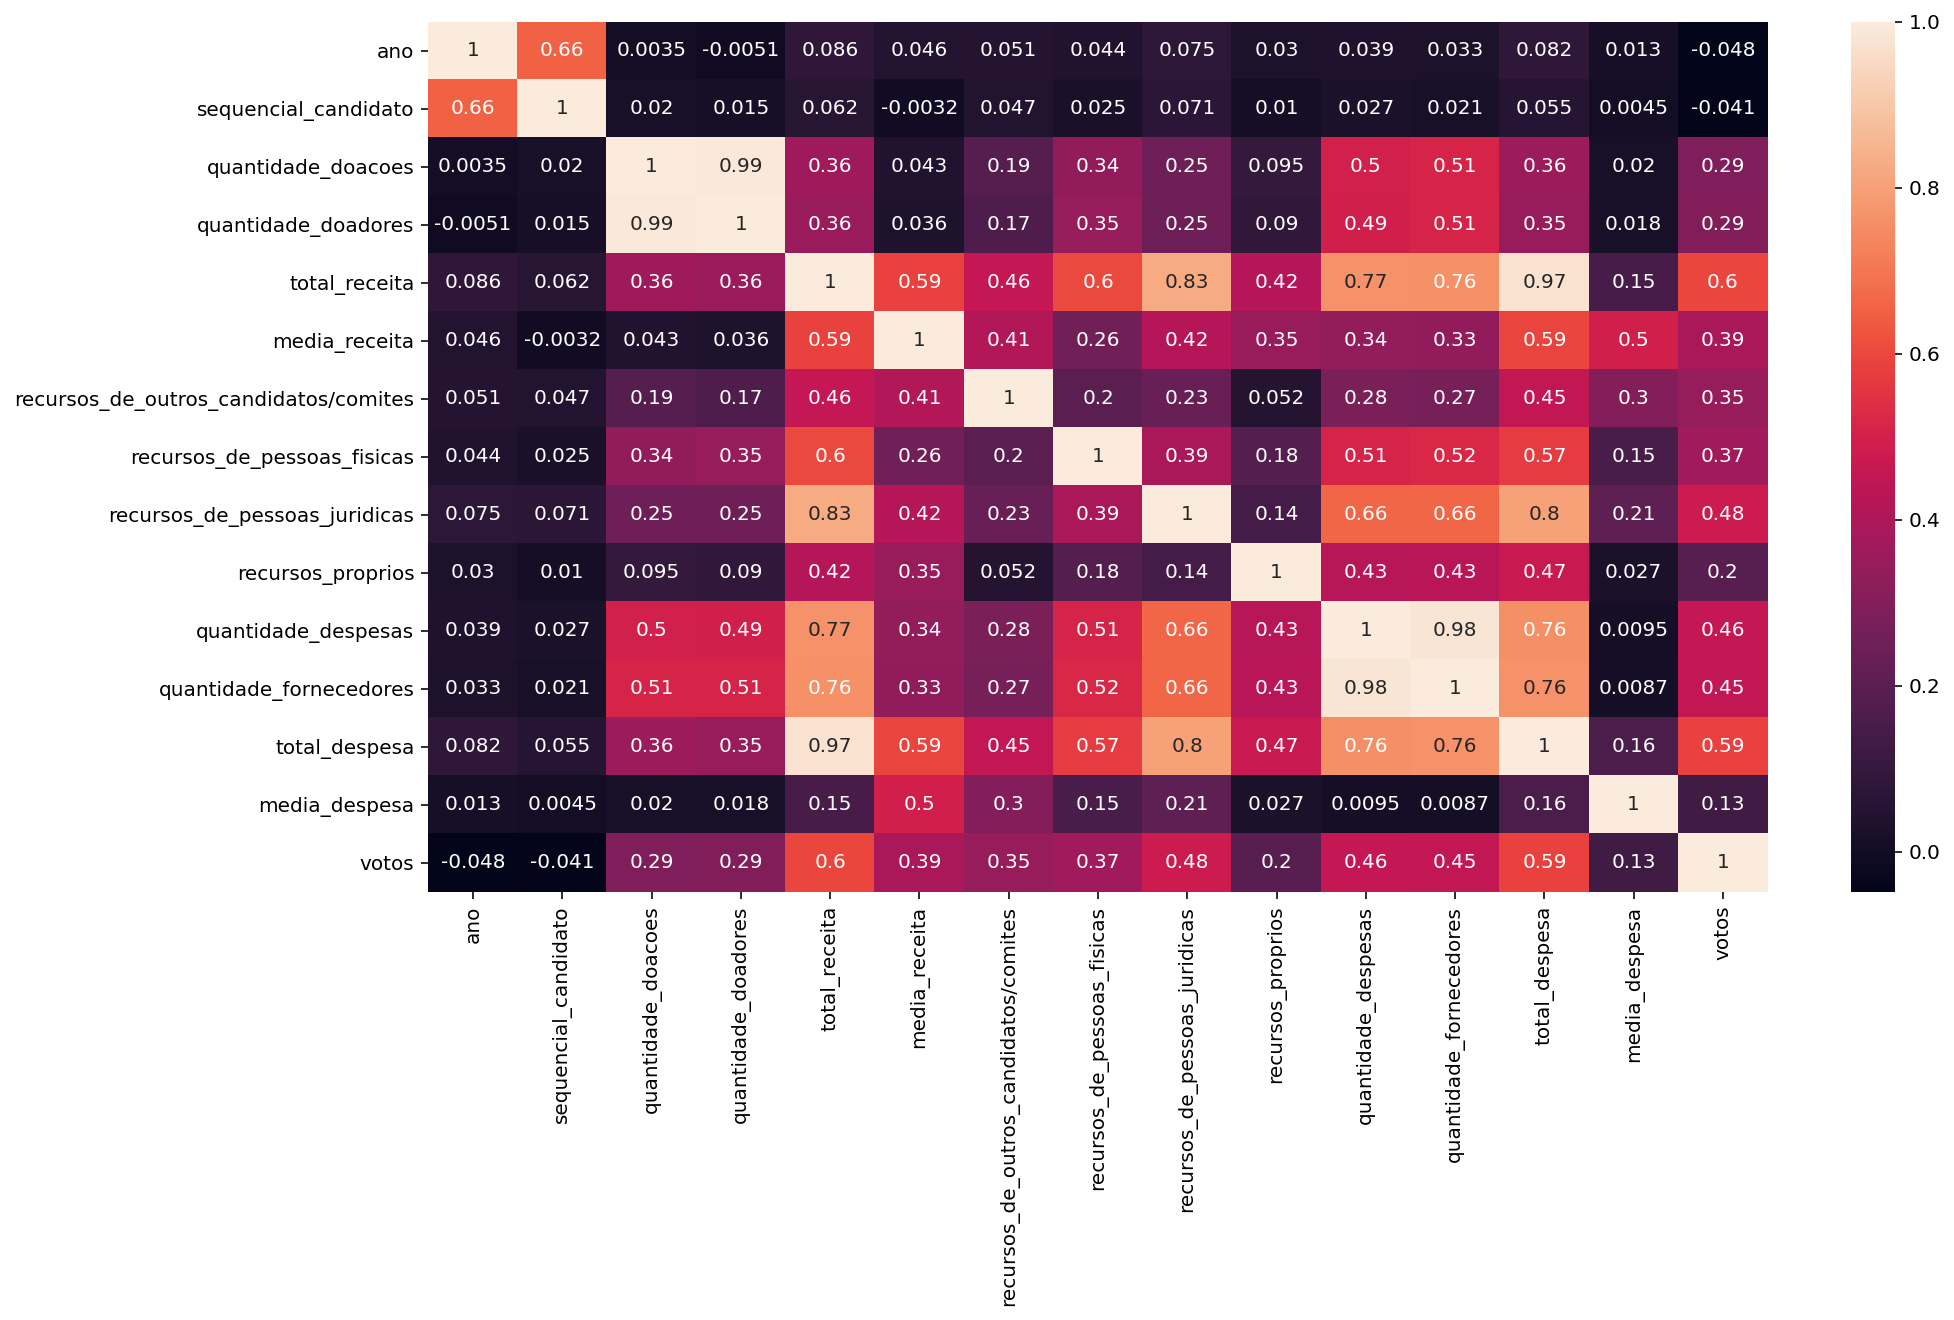

In [4]:
#Verificando a correlação entre as variáveis
correlacao = all_data.corr()
plt.figure(figsize = (15,8))
sns.heatmap(correlacao,annot = True)

Ajuste dos dados 

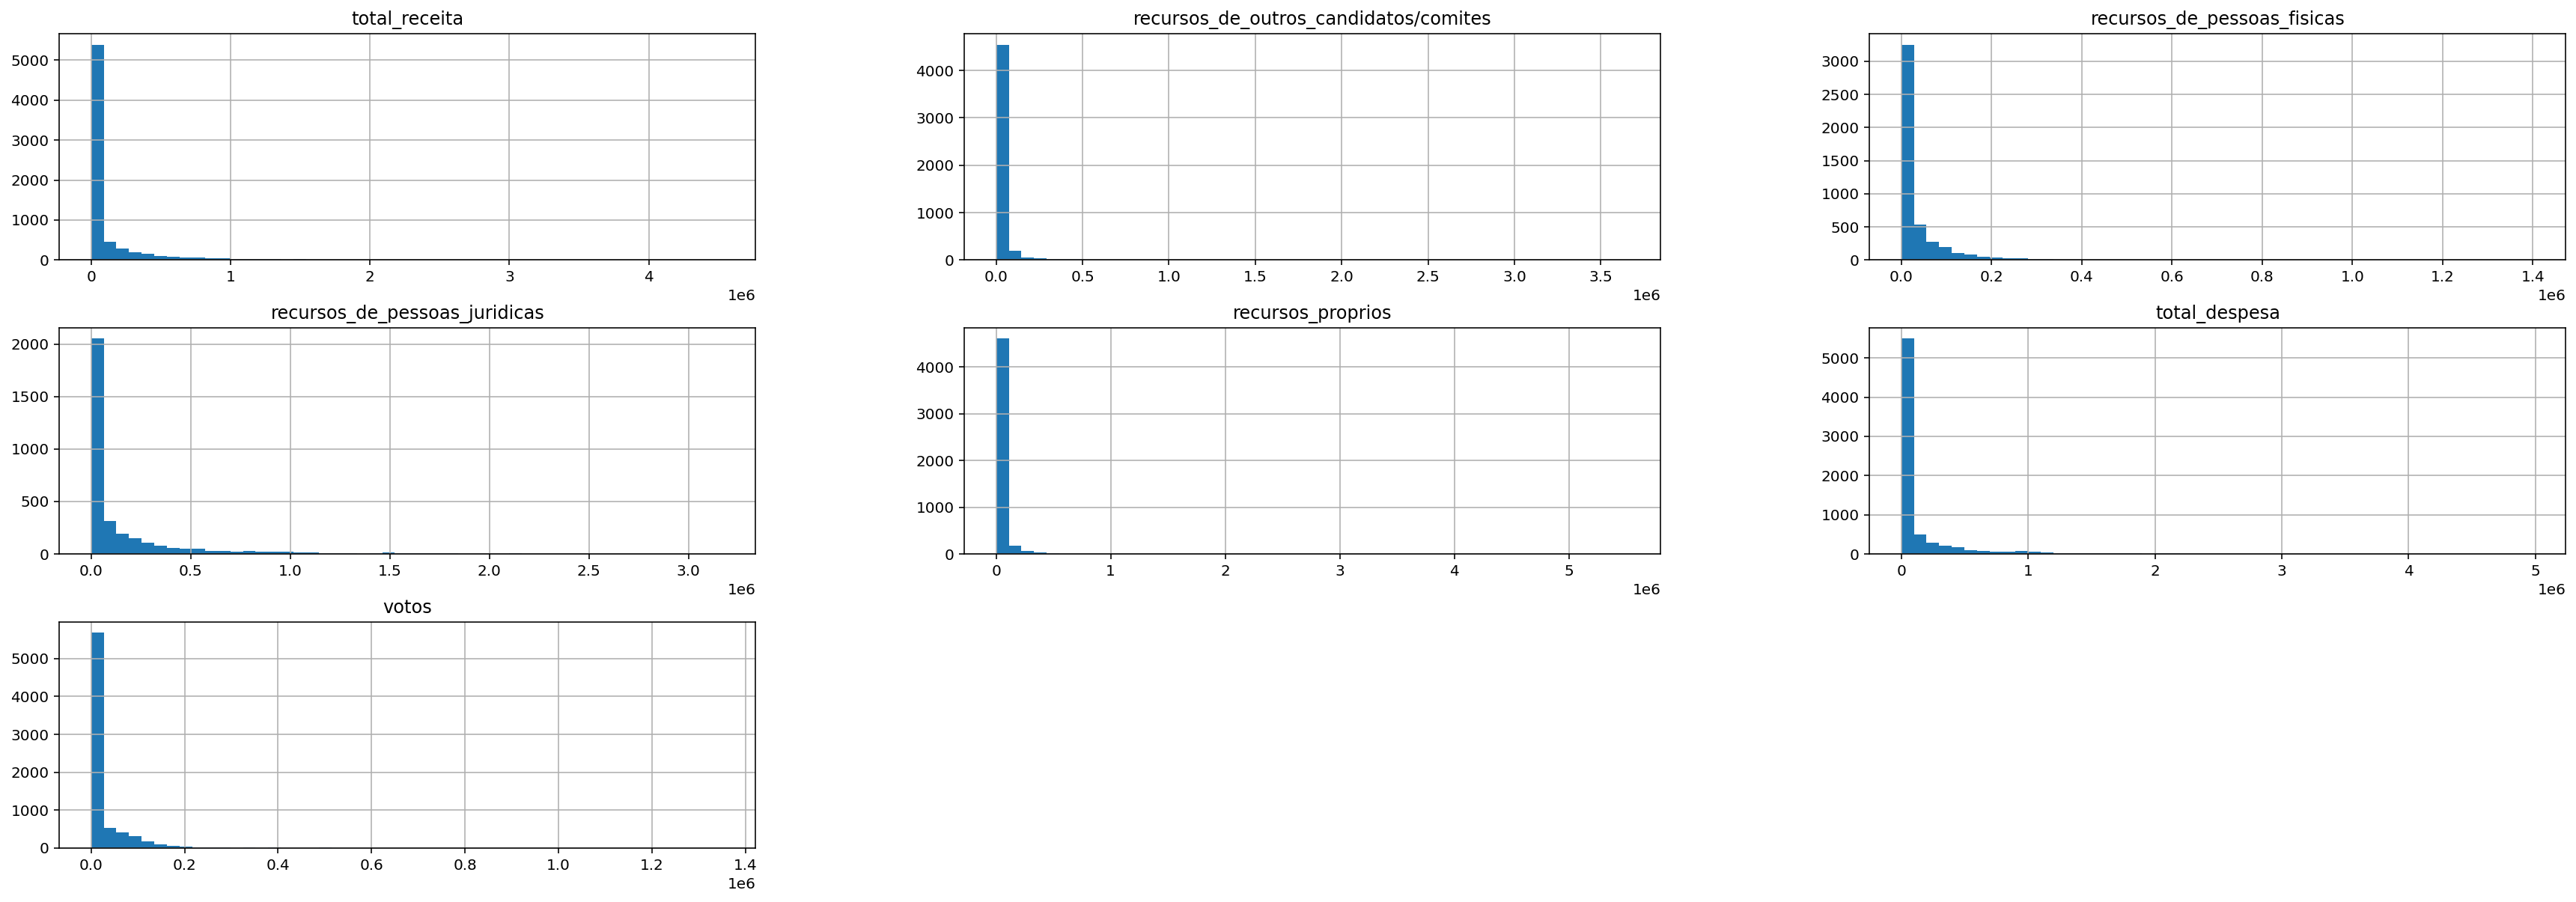

In [5]:
dados = train[['total_receita', 'recursos_de_outros_candidatos/comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios','total_despesa', 'votos']].hist(figsize=(30,10), bins=50);
dados;

Os gráficos acima mostram que todas as variáveis numéricas estão concentradas a esquerda, foi usado o log+1 para deixar a distribuição mais normalizados.

In [6]:
#Transformação dos dados - usando o logaritmo

train["votos"] = np.log1p(train["votos"])
numeric_feats = train.dtypes[train.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

train[skewed_feats] = np.log1p(train[skewed_feats])


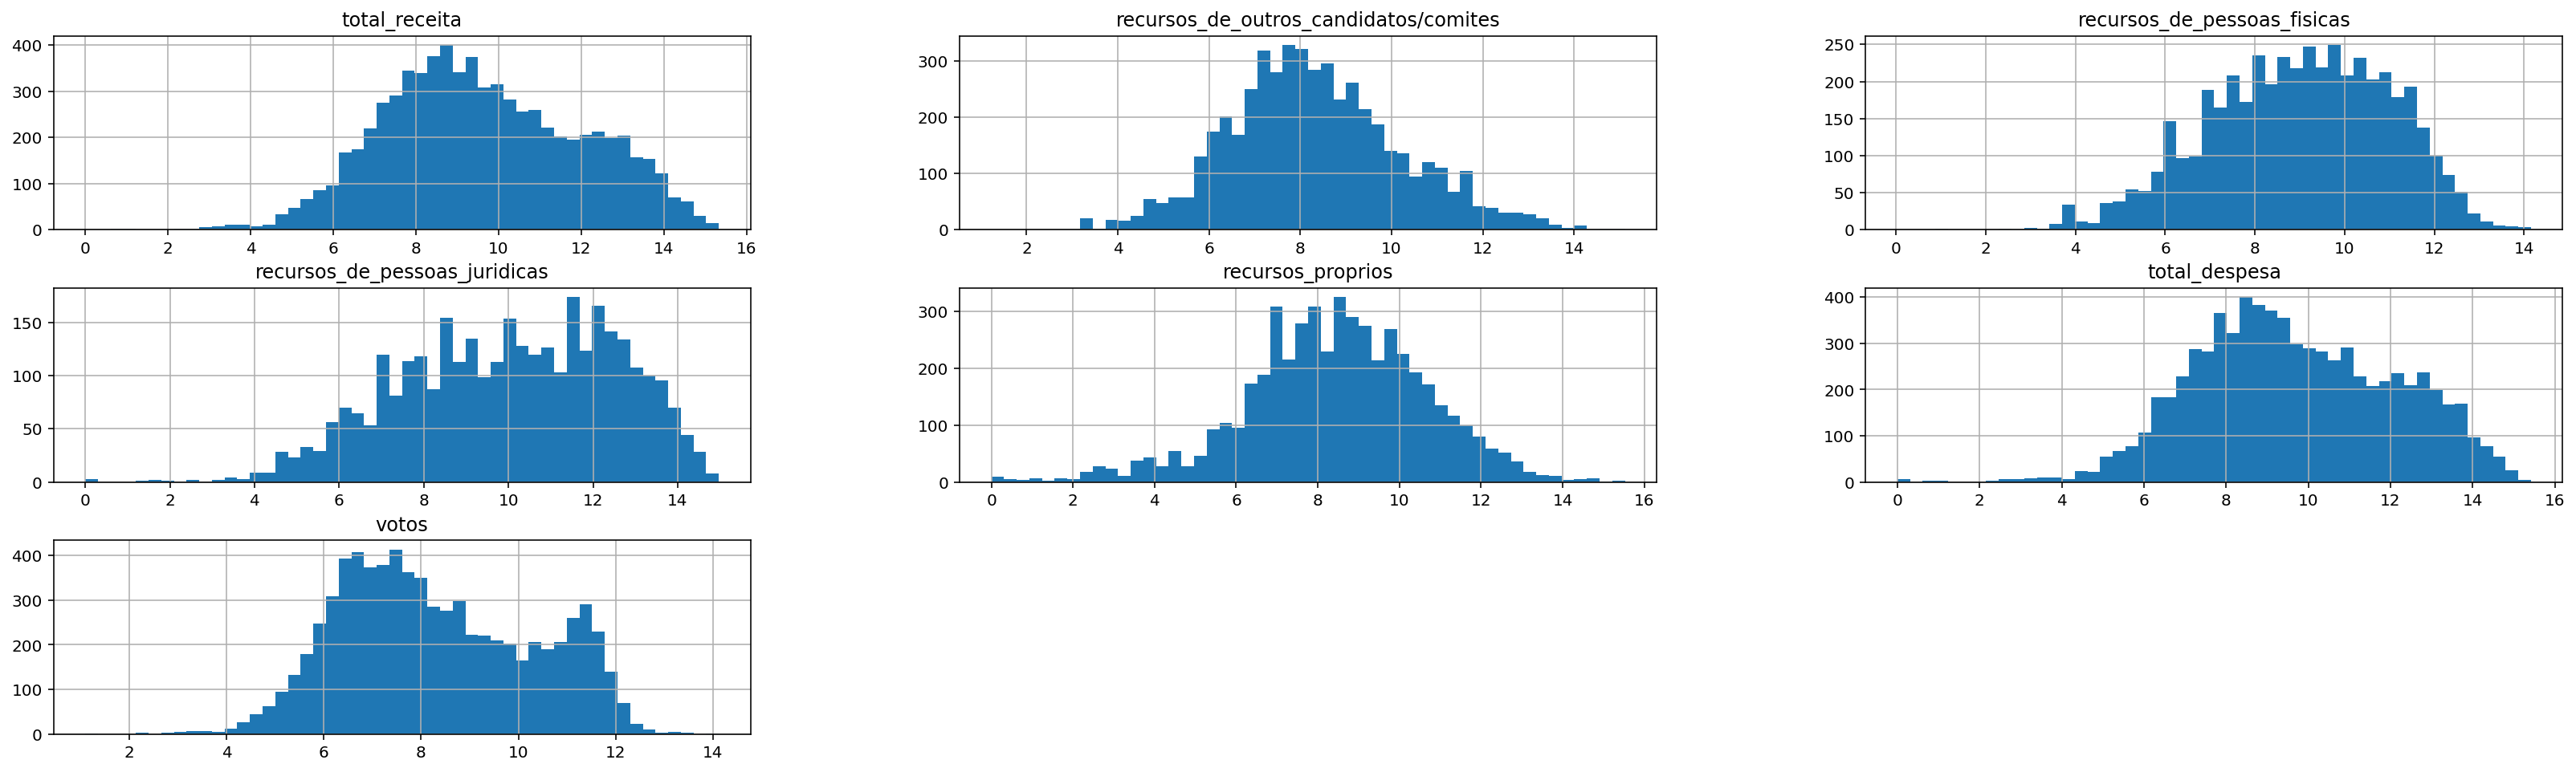

In [8]:
train[['total_receita', 'recursos_de_outros_candidatos/comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios','total_despesa', 'votos']].hist(figsize=(28,8), bins=50);

In [9]:
# Preenchendo dados nulos
train = train.fillna(train.mean())
test = test.fillna(test.mean())


### Treinando modelos


Foi realizada a validação dos modelos, pois por meio da validação foi possível se os dados tem ruídos ou se o modelo está viciado. Foi utilizada a validação cruzada foi usada para avaliar como os resultados das análises estatísticas foi generalizada para o conjunto de dados. Modelos foram utilizados:


+   Modelo Regressão linear sem ridge e lasso
+   Modelo Regressão linear ridge
+   Modelo Regressão linear lasso
+   KNN


#### Regressão linear sem Ridge e lasso

In [11]:
x = train.drop(['ano','sequencial_candidato', 'nome', 'uf', 'partido', 'cargo', 'sexo', 'grau',
       'estado_civil', 'ocupacao','votos'], axis=1)
y = train['votos'].values

In [12]:
#Gerando a matriz de correlação
x2 = x.iloc[:,:-1]
matriz_corr = x2.corr()
print(matriz_corr)

                                       quantidade_doacoes  \
quantidade_doacoes                               1.000000   
quantidade_doadores                              0.993554   
total_receita                                    0.795112   
media_receita                                    0.447392   
recursos_de_outros_candidatos/comites            0.441262   
recursos_de_pessoas_fisicas                      0.552477   
recursos_de_pessoas_juridicas                    0.369465   
recursos_proprios                                0.431941   
quantidade_despesas                              0.864433   
quantidade_fornecedores                          0.858354   
total_despesa                                    0.821086   

                                       quantidade_doadores  total_receita  \
quantidade_doacoes                                0.993554       0.795112   
quantidade_doadores                               1.000000       0.793140   
total_receita                       

In [13]:
x.isnull().apply(pd.value_counts)

,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa
False,7330,7330,7330,7330,7330,7330,7330,7330,7330,7330,7330,7330


In [14]:
# Criando MOdelo
modelo_l = linear_model.LinearRegression(normalize=True)
modelo_l.fit(x, y)
modelo_l.score(x, y)

0.7105265338176214

In [15]:
#Modelos de usando o teste

test["votos"] = np.log1p(test["votos"])
numeric_feats = test.dtypes[test.dtypes != "object"].index

skewed_feats = test[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

test[skewed_feats] = np.log1p(test[skewed_feats])

In [16]:
test_x = test.drop(['ano','sequencial_candidato', 'nome', 'uf', 'partido', 'cargo', 'sexo', 'grau',
       'estado_civil', 'ocupacao', 'votos'],axis=1)
test_y = test['votos'].values


In [86]:
test_p = modelo_l.predict(test_x)

In [18]:
print("RMSE squared error: %.2f" % mean_squared_error(test_y, test_p, squared = False))

RMSE squared error: 1.93


In [19]:
#matriz de correlação com variavel ´preditora 
for coef, var in sorted(zip(modelo_l.coef_, x.columns[:-1]), reverse = True):
    print ("%6.3f %s" % (coef,var))

 0.984 quantidade_fornecedores
 0.966 quantidade_doadores
 0.432 media_receita
 0.294 quantidade_despesas
 0.041 recursos_de_pessoas_fisicas
 0.029 recursos_de_pessoas_juridicas
 0.020 recursos_proprios
-0.008 recursos_de_outros_candidatos/comites
-0.152 total_receita
-0.325 quantidade_doacoes
-0.812 total_despesa


<AxesSubplot:xlabel='preds', ylabel='residuals'>

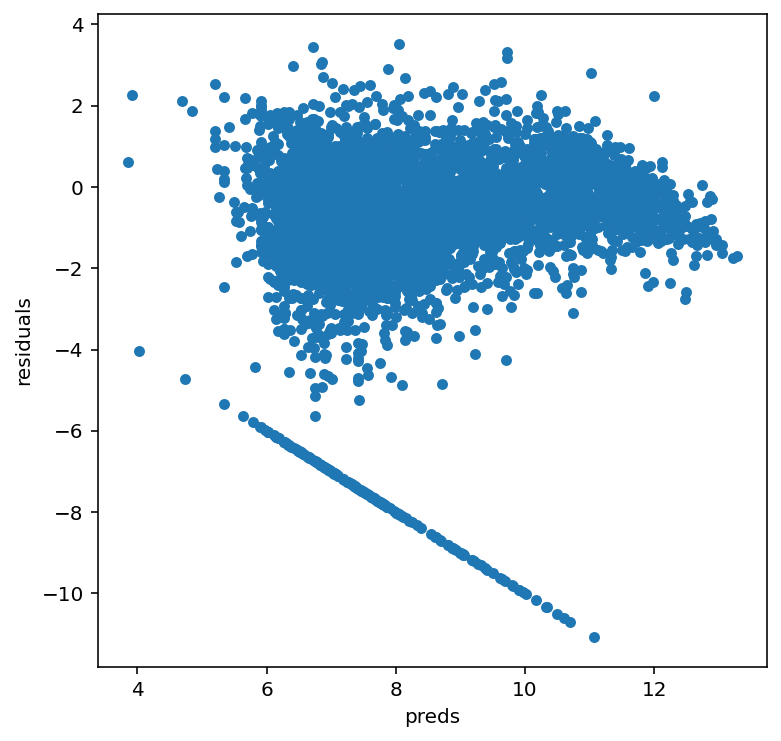

In [20]:
#Vesiduos de Regressão linear sem Ridge e lasso
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":modelo_l.predict(test_x), "true":test_y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

#### Regressão linear Ridge

In [22]:
from sklearn.linear_model import Ridge, Lasso, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv_r_l(model):
    rmse= np.sqrt(-cross_val_score(model, x_, y_, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [87]:
from sklearn import linear_model
modelo_Ridge = RidgeCV(alphas = [1,0.1, 0.001, 0.0005]).fit(x, y)
modelo_Ridge.fit(x,y)

pred_Ridge_y = modelo_Ridge.predict(test_x)

print("RMSE squared error: %.2f" % mean_squared_error(test_y, pred_Ridge_y, squared = False))

RMSE squared error: 1.93


<AxesSubplot:xlabel='preds', ylabel='residuals'>

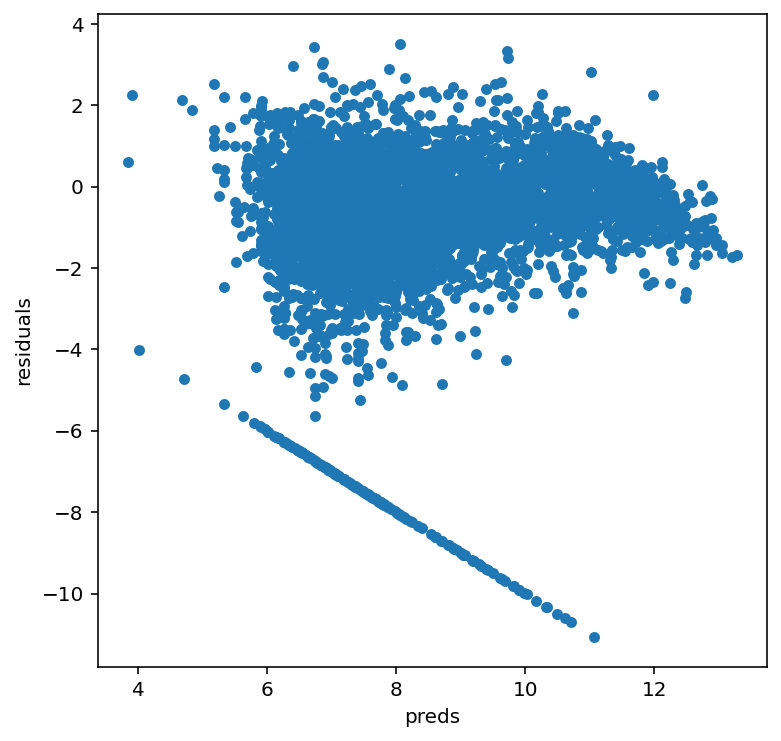

In [35]:
#Vesiduos de Regressão linear Ridge
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":modelo_Ridge.predict(test_x), "true":test_y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [31]:
preds

,preds,true,residuals
0,7.137131,3.637586,-3.499545
1,7.604829,5.950643,-1.654186
2,10.423813,10.182974,-0.240840
3,9.959610,9.199987,-0.759623
4,11.340971,9.946403,-1.394567
...,...,...,...
4931,8.088139,5.198497,-2.889642
4932,11.542686,10.502269,-1.040417
4933,7.024217,5.327876,-1.696340
4934,6.801074,5.389072,-1.412003


#### Regressão linear Lasso

In [39]:
modelo_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(x, y)
pred_lasso_y = modelo_lasso.predict(test_x)
print("RMSE squared error: %.2f" % mean_squared_error(test_y, pred_lasso_y, squared = False))

RMSE squared error: 1.94


<AxesSubplot:xlabel='preds', ylabel='residuals'>

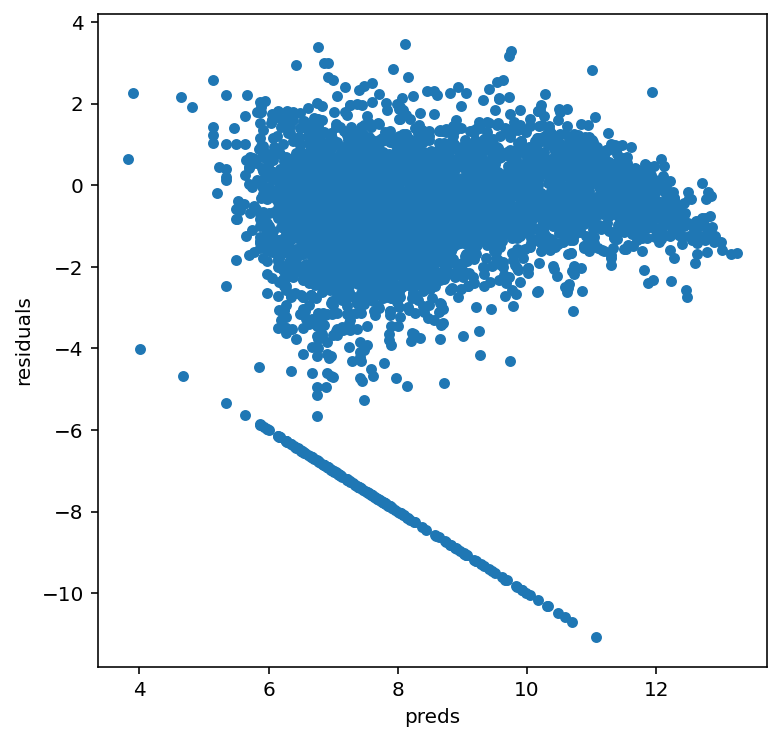

In [41]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":modelo_lasso.predict(test_x), "true":test_y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [42]:
preds

,preds,true,residuals
0,6.758999,3.637586,-3.121413
1,7.225174,5.950643,-1.274531
2,10.514938,10.182974,-0.331964
3,10.038547,9.199987,-0.838560
4,11.495713,9.946403,-1.549310
...,...,...,...
4931,7.676278,5.198497,-2.477781
4932,11.787316,10.502269,-1.285047
4933,6.630979,5.327876,-1.303102
4934,6.480806,5.389072,-1.091734


### KNN


In [61]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model, X_train, y, cv_num):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = cv_num))
    return(rmse)

In [70]:
rmse_val = []
for K in range(20):
    K = K+1
    modelo_knn = neighbors.KNeighborsRegressor(n_neighbors = K)

    modelo_knn.fit(x, y)
    pred_knn_y = modelo_knn.predict(test_x)
    error = mean_squared_error(test_y, pred_knn_y, squared = False)
    rmse_val.append(error)
    print('RMSE para o valor de k = ' , K , 'é:', error)

RMSE para o valor de k =  1 é: 2.200585941624943
RMSE para o valor de k =  2 é: 2.090732378158164
RMSE para o valor de k =  3 é: 2.0397885819226254
RMSE para o valor de k =  4 é: 2.015308826910479
RMSE para o valor de k =  5 é: 2.0015123972623985
RMSE para o valor de k =  6 é: 1.9927020372207251
RMSE para o valor de k =  7 é: 1.9829327299943338
RMSE para o valor de k =  8 é: 1.9784806046883672
RMSE para o valor de k =  9 é: 1.9732227320049207
RMSE para o valor de k =  10 é: 1.9687050489736078
RMSE para o valor de k =  11 é: 1.9639234496673164
RMSE para o valor de k =  12 é: 1.9592175262540297
RMSE para o valor de k =  13 é: 1.9585400316599
RMSE para o valor de k =  14 é: 1.9574143834717481
RMSE para o valor de k =  15 é: 1.9534036770137129
RMSE para o valor de k =  16 é: 1.9515382010444646
RMSE para o valor de k =  17 é: 1.9517949664272405
RMSE para o valor de k =  18 é: 1.9526219494420494
RMSE para o valor de k =  19 é: 1.9508312174579017
RMSE para o valor de k =  20 é: 1.948098474567

Text(0, 0.5, 'RSMS')

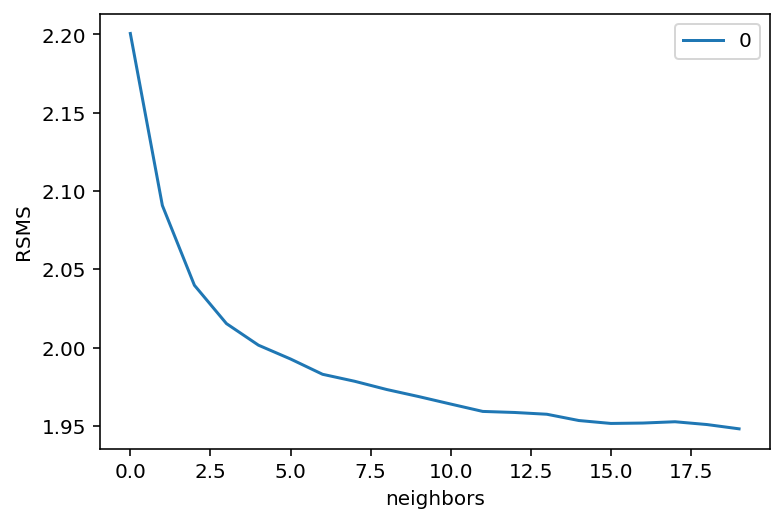

In [69]:
c = pd.DataFrame(rmse_val)
c.plot( )
plt.legend()
plt.xlabel('neighbors')
plt.ylabel('RSMS')

<AxesSubplot:xlabel='preds', ylabel='residuals'>

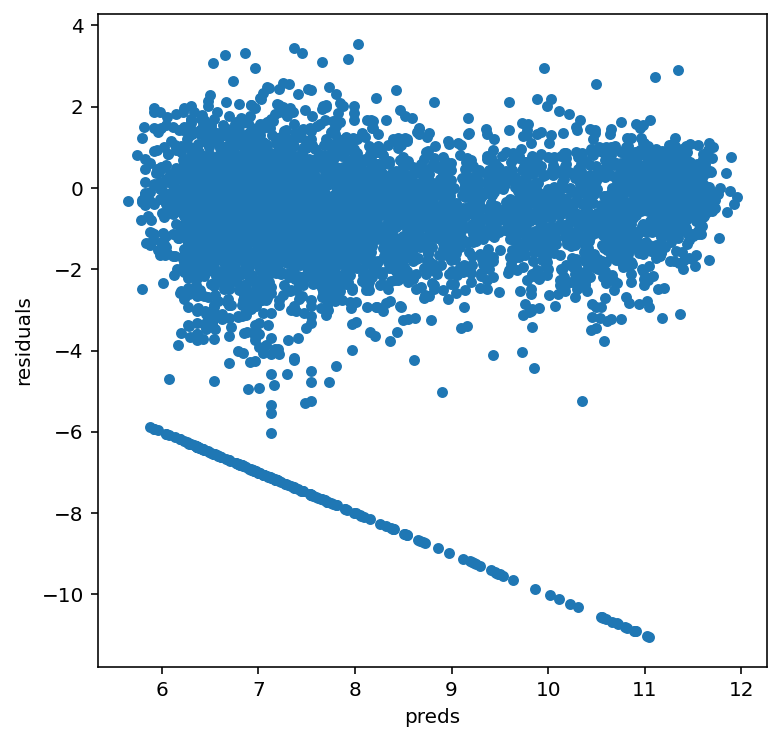

In [81]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":modelo_knn.predict(test_x), "true":test_y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")


Ao observar os gráficos dos resíduas versos predição, é possível afirmar que os modelos se comportam de forma semelhante. Os modelos predizem bem o conjunto de dados, pois conseguiram realizar generalização relativamente bem ao conjunto de dados.

Considerando as métricas usadas para avaliar os modelos, podemos afirmar que a regressão linear sem regularização juntamente com Ridge apresentaram melhores resultados, seguido por lasso e depois knn. Vale salientar que a diferença entre os modelos é muito pequena.